## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

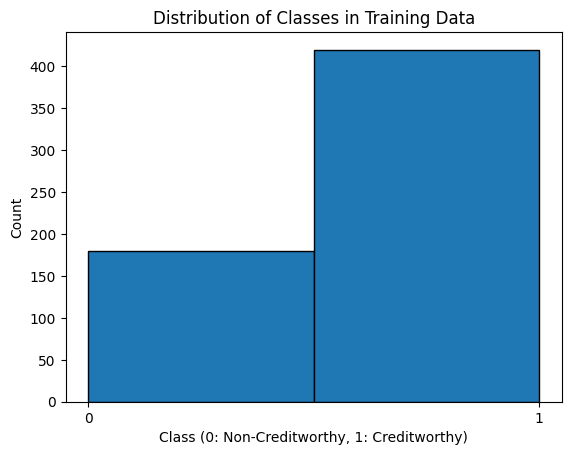

In [515]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Создание модели Logistic Regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
logistic_regression_grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), log_reg_params, cv=5, scoring='roc_auc')
logistic_regression_grid.fit(X_train_selected, y_train)
logistic_regression_model = logistic_regression_grid.best_estimator_

# Создание модели Decision Tree
tree_params = {
    'max_depth': [2, 4, 6, 8, 10],                 
    'min_impurity_decrease': [0.008],
    'splitter': ['best', 'random'],                  
    'max_leaf_nodes': [10],     
}

kfold = KFold(n_splits=10, random_state=42, shuffle=True)

decision_tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_params, 
    cv=kfold, 
    scoring='roc_auc'
)

decision_tree_grid.fit(X_train_selected, y_train)
decision_tree_model = decision_tree_grid.best_estimator_

# Создание модели K-Nearest Neighbors
knn_params = {'n_neighbors': range(5, 30, 5), 'metric': ['euclidean', 'manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='roc_auc')
knn_grid.fit(X_train_selected, y_train)
knn_model = knn_grid.best_estimator_

In [18]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.7275
Accuracy of Decision Tree: 0.7375
Accuracy of K-Nearest Neighbors: 0.74
ROC AUC of Logistic Regression: 0.8038095238095238
ROC AUC of Decision Tree: 0.7457142857142857
ROC AUC of K-Nearest Neighbors: 0.8121875
Precision of Logistic Regression: 0.8766519823788547
Precision of Decision Tree: 0.7581120943952803
Precision of K-Nearest Neighbors: 0.7365591397849462
Recall of Logistic Regression: 0.7107142857142857
Recall of Decision Tree: 0.9178571428571428
Recall of K-Nearest Neighbors: 0.9785714285714285


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели